In [1]:
# load functions for data analysis
from scr_analysis_functions_fyp import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/analysis/data_physio_study1'
day1 = experimental(data_path)
day1.day = 1
day1.preprocessData()

In [3]:
day2 = experimental(data_path)
day2.day = 2
day2.preprocessData()

In [4]:
cb = []
bc = []
for iSubject in range(0,len(day2.subjectNames)): 
    if str.find(day2.subjectNames[iSubject],'_cb_') != -1: 
        cb.append(iSubject)
    else: 
        bc.append(iSubject)

cb = np.array(cb)
bc = np.array(bc)

In [29]:
iStim = 4
day1.nSeconds = 5
plus, minus = day1.amplitudeDifference('trans',iStim,'onset');

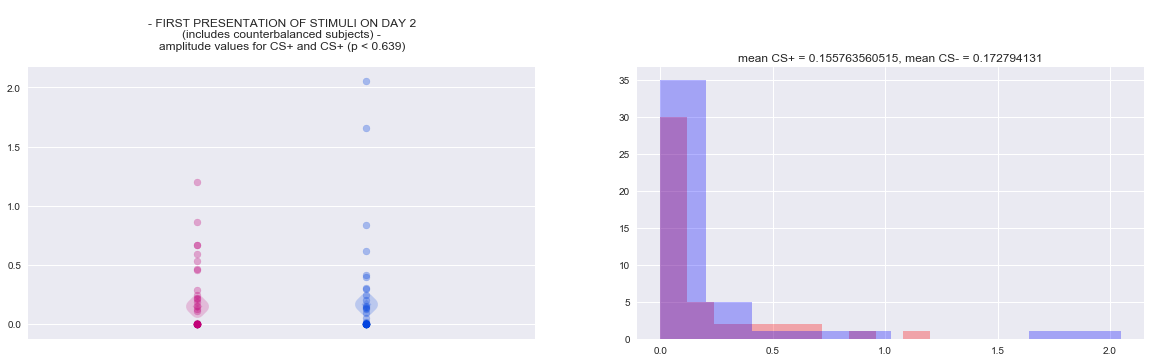

In [30]:
results = scipy.stats.wilcoxon(plus,minus);
visualizeStats(plus,minus,results, 
               heading='FIRST PRESENTATION OF STIMULI ON DAY 2\n(includes counterbalanced subjects)')

In [7]:
CSPs = np.zeros([day1.nSubjects,len(range(3,12))])
CSMs = np.zeros([day1.nSubjects,len(range(3,12))])

day1.nSeconds = 5
conditioning = list(range(3,12))
for iStim in range(0,len(conditioning)):
    CSPs[:,iStim], CSMs[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'offset');
    
conResultsS = np.zeros(day1.nSubjects)
for iSubject in range(0,day1.nSubjects): 
    conResultsS[iSubject] = scipy.stats.wilcoxon(CSPs[iSubject,:],CSMs[iSubject,:])[1];

conditionedSubjects = find(conResultsS<.05)

In [8]:
# wrongConditioned = find(mean(CSPs[conditionedSubjects,:] - CSMs[conditionedSubjects,:],1)<0)
# print('%s was conditioned to CS- and said the CS+ was blue...'%day1.subjectNames[wrongConditioned])
# #conditionedSubjects = np.delete(conditionedSubjects,wrongConditioned)

In [9]:

sInd = 4
eInd = 13
CSP = np.zeros([day1.nSubjects,len(range(sInd,eInd))])
CSM = np.zeros([day1.nSubjects,len(range(sInd,eInd))])

day1.nSeconds = 4
conditioning = list(range(sInd,eInd))

for iStim in range(0,len(conditioning)):
    CSP[:,iStim], CSM[:,iStim] = day1.amplitudeDifference('trans',conditioning[iStim],'onset');
    
conResults = np.zeros(day1.nSubjects)

for iSubject in range(0,day1.nSubjects): 
    conResults[iSubject] = scipy.stats.wilcoxon(log(1+CSP[iSubject,:]),log(1+CSM[iSubject,:]))[1];
    

In [10]:

def results_vary_p(p_value): 
    
    conditionedSubjects = find(conResults < p_value)

    cbSubs = 0 
    for iSubject in conditionedSubjects: 
        if iSubject in cb: cbSubs = cbSubs + 1
    bcSubs = 0 
    for iSubject in conditionedSubjects: 
        if iSubject in bc: bcSubs = bcSubs + 1
    print 'with a threshhold of p < ', p_value,'total subjects:', bcSubs + cbSubs, 'counterbalanced subjects:', cbSubs
    
    iStim = 0
    day2.nSeconds = 4.5
    plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

    pConditioned = plus[conditionedSubjects]
    mConditioned = minus[conditionedSubjects]

    results = scipy.stats.wilcoxon(pConditioned, mConditioned)
    visualizeStats(pConditioned,mConditioned,results, 
                   heading='in participants with predictions on day 1 (p < %s)'%p_value)

with a threshhold of p <  0.1 total subjects: 10 counterbalanced subjects: 3


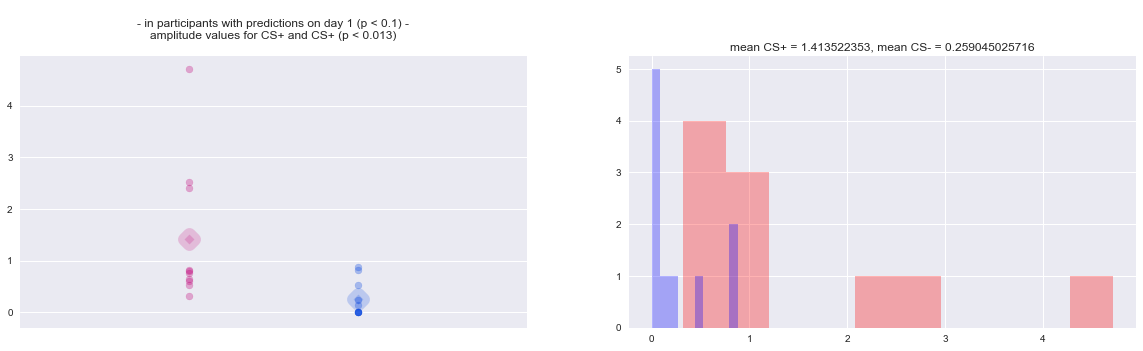

In [11]:
results_vary_p(.1)

with a threshhold of p <  0.05 total subjects: 5 counterbalanced subjects: 2


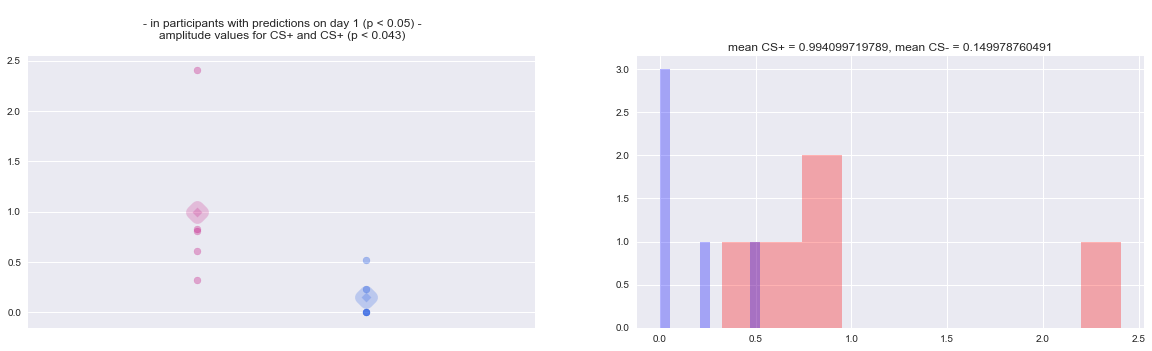

In [12]:
results_vary_p(.05)

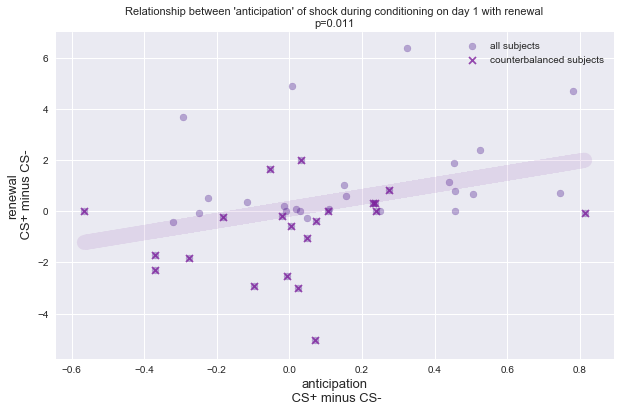

In [51]:
figure(figsize=(10,6))

iStim = 0
day2.nSeconds = 4.5
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

var1 = mean(CSP - CSM,1)#[conditionedSubjects]
var2 =  plus - minus #plus[conditionedSubjects]-minus[conditionedSubjects]

tmp = smf.OLS(var2,var1).fit()
scatter(var1,var2,color='xkcd:indigo',alpha=.3,label='all subjects')
scatter(var1[cb],var2[cb],color='xkcd:purple',alpha=.8,marker='x',label='counterbalanced subjects')

plot(var1, tmp.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)
legend()
xlabel('anticipation\n CS+ minus CS-',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title('Relationship between \'anticipation\' of shock during conditioning on day 1 with renewal\np=%.3f'%(tmp.pvalues),fontsize=11)

In [50]:
from scipy import stats

In [53]:
responders = abs(minus) > .1

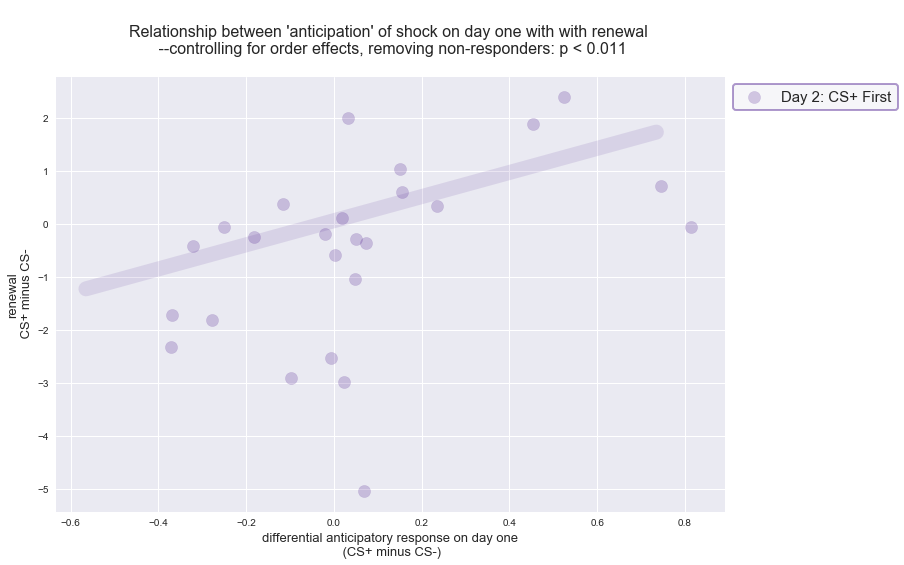

In [58]:
figure(figsize=[12, 8])

scatter(var1[responders], var2[responders], color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ First')

#scatter(var1[responders][cb], var2[responders][cb], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')
use_lim = np.arange(min(var1), max(var1), .1)
edge_function = np.polyfit(var1, var2, 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

leg = legend(fontsize=15, fancybox=True, frameon=True, bbox_to_anchor=(.269, 1, 1, 0))
leg.get_frame().set_edgecolor('xkcd:indigo')
leg.get_frame().set_linewidth(2)
leg.get_frame().set_alpha(.4)

xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% (tmp.pvalues),fontsize=16); 

In [14]:
# figure(figsize=(10,5))

# var1 = mean(CSP[cb] - CSM[cb], 1)
# var2 =  plus[cb] -  minus[cb] 

# tmpCB = smf.OLS(var2, var1).fit()

# scatter(var1, var2, color='xkcd:purple', alpha=.8, marker='x', label='counterbalanced subjects')

# plot(var1, tmpCB.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)
# legend()
# title('relationship between anticipation of shock on day with renewal on day 2\n p < %.4f, r^2 = %.2f'
#       %(tmpCB.pvalues, tmpCB.rsquared))


In [15]:
responders = abs(plus - minus) >.01

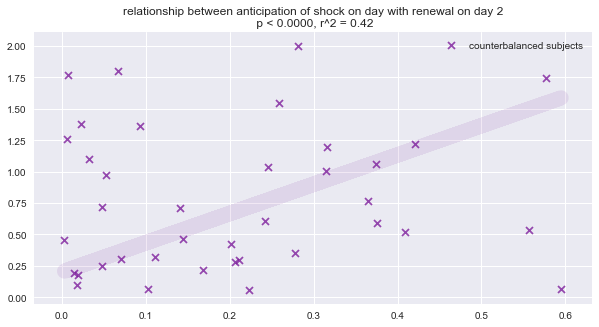

In [16]:
figure(figsize=(10,5))

var1 = log(1 + abs(mean(CSP[responders] - CSM[responders], 1)))
var2 =  log(1 + abs(plus[responders] -  minus[responders]))

tmpCB = smf.OLS(var2, var1).fit()

scatter(var1, var2, color='xkcd:purple', alpha=.8, marker='x', label='counterbalanced subjects')

plot(var1, tmpCB.predict(var1) + mean(var1), color='xkcd:purple',linewidth=15,alpha=.1)
legend()
title('relationship between anticipation of shock on day with renewal on day 2\n p < %.4f, r^2 = %.2f'
      %(tmpCB.pvalues, tmpCB.rsquared)); 


In [17]:
# CREATE A DATA FRAME FOR PHYSIO 

# response to first US
iStim = 4
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus - USminus

# last stimulus from extinction
iStim = 21
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus - minus) - (plus_end - minus_end)

# difference across conditioning
difference = mean(CSP - CSM,1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [18]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df         F    PR(>F)
prediction   30.797348   1.0  5.888511  0.019506
Residual    224.893196  43.0       NaN       NaN


In [19]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df          F    PR(>F)
C(order)     48.700991   1.0  11.637540  0.001465
US           14.652865   1.0   3.501434  0.068463
prediction   16.883577   1.0   4.034483  0.051196
Residual    171.577549  41.0        NaN       NaN


In [20]:
physio = pandas.DataFrame() 
#physio['firstMinusLast'] = ( plusRen - minusRen ) - (plusEnd - minusEnd)
physio['renewal'] = renewal
physio['prediction'] = mean(log(1+CSP)- log(1+CSM),1)
#physio['resonance'] = resonance
physio['US'] = US

#physioTitleNames = ['firstMinusLast','renewal','prediction','US','resonance','meanSurprise']
physioTitleNames = ['renewal','prediction','first US']

renewalPredictionCorr = physio['renewal'].corr(physio['prediction'])
physio.corr()

,renewal,prediction,US
renewal,1.000000,0.318535,-0.065455
prediction,0.318535,1.000000,0.129677
US,-0.065455,0.129677,1.000000


# create a model removing non-responders! 

In [40]:
# CREATE A DATA FRAME FOR PHYSIO removing non-responders

# response to first US
iStim = 4
#USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = log(1 + USplus) - log(1 + USminus)
#US = USplus - USminus

# last stimulus from extinction
iStim = -1
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

# renewal on day 2
renewal = (log(1 + plus) - log(1 + minus)) - (log(1 + plus_end) - log(1 + minus_end))
#renewal =  (plus - minus) - (plus_end - minus_end)


# difference across conditioning
difference = mean(log(1 + CSP) - log(1 + CSM),1) #difference = log(1 + difference)
#difference = mean(CSP - CSM, 1) #difference = log(1 + difference)

# define non-responders as those who dont respond at all to the CS- on day two--better definition? 
responders = abs(minus) > .01

# create data frame
SCR = pandas.DataFrame({'renewal':renewal[responders],
                        'prediction':difference[responders],
                        'US':US[responders],
                        'order':order[responders]})

In [22]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq    df         F    PR(>F)
prediction   5.810602   1.0  5.447301  0.028698
Residual    24.533957  23.0       NaN       NaN


In [23]:
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
p_value = aov_table.values[2,3]
print(aov_table)

               sum_sq    df          F    PR(>F)
C(order)     7.804749   1.0  11.025726  0.003250
US           3.985337   1.0   5.630063  0.027281
prediction   3.654020   1.0   5.162014  0.033718
Residual    14.865210  21.0        NaN       NaN


# BOOM! SIGNIFICANCE CONTROLLING FOR ORDER!!?!! :::laughs::: 

In [24]:
iStim = 0
day2.nSeconds = 4.5

plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
var1 = mean(log(1 + CSP[responders]) - log(1 + CSM[responders]),1)
var2 =  log(1 + plus[responders]) - log(1 + minus[responders]) 
#var1 = mean(CSP[responders] - CSM[responders], 1)
#var2 =  plus[responders] - minus[responders]

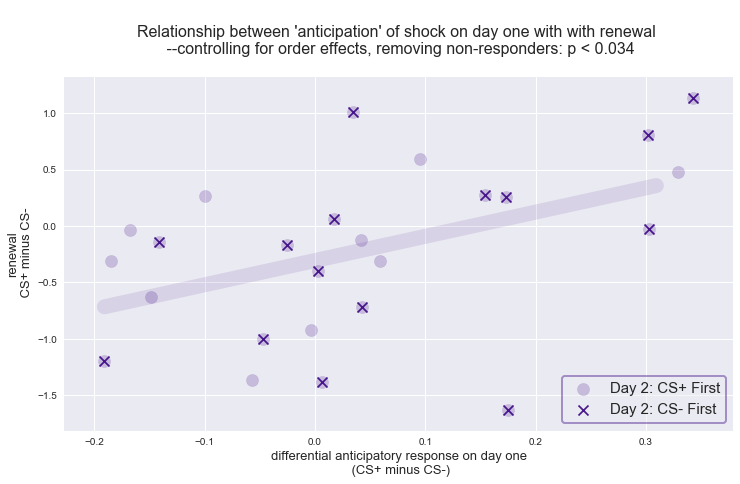

In [25]:
figure(figsize=[12, 6.5])

cb_controlled = responders[cb]
scatter(var1, var2, color='xkcd:indigo',alpha=.2, s=150, label='Day 2: CS+ First')

scatter(var1[cb_controlled], var2[cb_controlled], marker='x', color='xkcd:indigo',alpha=.9, s=100, label='Day 2: CS- First')
use_lim = np.arange(min(var1), max(var1), .1)
edge_function = np.polyfit(var1, var2, 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

leg = legend(fontsize=15, fancybox=True, frameon=True, loc=4) #bbox_to_anchor=(.2, 1, 1, 0))
leg.get_frame().set_edgecolor('xkcd:indigo')
leg.get_frame().set_linewidth(2)
leg.get_frame().set_alpha(.4)

xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% p_value,fontsize=16); 

# look at whether differential response on day one --> "renewal" to anything

In [26]:
# CREATE A DATA FRAME FOR PHYSIO removing non-responders

# response to first US
iStim = 3

USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = log(1 + USplus) - log(1 + USminus)
#US = USplus - USminus

# last stimulus from extinction
iStim = -1
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');

# renewal on day 2
renewal = ((log(1 + plus) - log(1 + minus)) - (log(1 + plus_end) - log(1 + minus_end)))
#renewal =  abs((plus - minus)) - (plus_end - minus_end))


# difference across conditioning
difference = abs(mean(log(1 + CSP) - log(1 + CSM),1)) #difference = log(1 + difference)
#difference = (mean(CSP - CSM, 1)) #difference = log(1 + difference)

# define non-responders as those who dont respond at all to the CS- on day two--better definition? 
responders = abs(log(1 + minus)) > .01

# create data frame
SCR = pandas.DataFrame({'renewal':renewal[responders],
                        'prediction':difference[responders],
                        'US':US[responders],
                        'order':order[responders]})

In [27]:
formula = 'renewal ~ prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
p_value = aov_table.values[2,3]
print(aov_table)

               sum_sq    df         F    PR(>F)
C(order)     4.727781   1.0  5.053186  0.034935
prediction   1.611655   1.0  1.722583  0.202889
Residual    20.583288  22.0       NaN       NaN


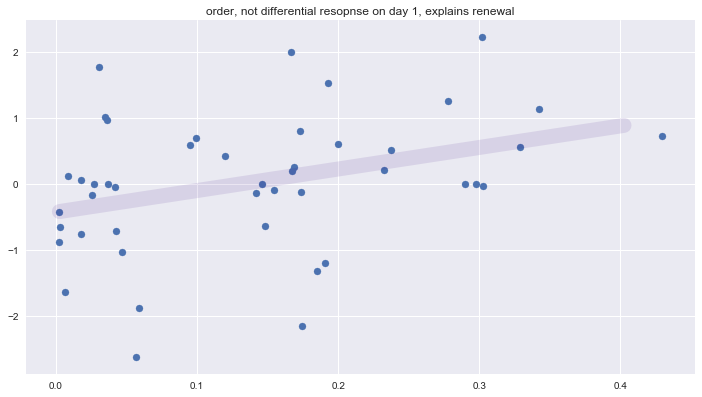

In [28]:
figure(figsize=[12, 6.5])

use_lim = np.arange(min(difference), max(difference), .1)
edge_function = np.polyfit(difference, renewal, 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

scatter(difference, renewal)
title('order, not differential resopnse on day 1, explains renewal')

In [489]:
# iStim = 0
# day2.nSeconds = 4.5

# plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# var1 = mean(log(1 + CSP) - log(1 + CSM),1)
# var2 =  log(1 + plus) - log(1 + minus) 

# figure(figsize=[12, 6.5])

# cb_controlled = responders[cb]
# scatter(var1, var2, color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS+ First')

# scatter(var1[cb_controlled], var2[cb_controlled], marker='D', color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS- First')

# use_lim = np.arange(min(var1), max(var1), .1)
# edge_function = np.polyfit(var1, var2, 1)
# function_ = np.poly1d(edge_function)
# line_fit = function_(use_lim)
# plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

# leg = legend(fontsize=15, fancybox=True, frameon=True, loc=4) #bbox_to_anchor=(.2, 1, 1, 0))
# leg.get_frame().set_edgecolor('xkcd:indigo')
# leg.get_frame().set_linewidth(2)
# leg.get_frame().set_alpha(.4)

# xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
# ylabel('renewal\n CS+ minus CS-',fontsize=13)
# title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% p_value,fontsize=16); 

In [ ]:
iStim = 0
day2.nSeconds = 4.5

plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
var1 = mean(log(1 + CSP[responders]) - log(1 + CSM[responders]),1)
var2 =  log(1 + plus[responders]) - log(1 + minus[responders]) 
#var1 = mean(CSP[responders] - CSM[responders], 1)
#var2 =  plus[responders] - minus[responders]

In [ ]:
figure(figsize=[12, 6.5])

cb_controlled = responders[cb]
scatter(var1, var2, color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS+ First')

scatter(var1[cb_controlled], var2[cb_controlled], marker='D', color='xkcd:indigo',alpha=.5, s=100, label='Day 2: CS- First')

use_lim = np.arange(min(var1), max(var1), .1)
edge_function = np.polyfit(var1, var2, 1)
function_ = np.poly1d(edge_function)
line_fit = function_(use_lim)
plot(use_lim, line_fit, alpha=.1, linewidth=15, color='xkcd:indigo')

leg = legend(fontsize=15, fancybox=True, frameon=True, loc=4) #bbox_to_anchor=(.2, 1, 1, 0))
leg.get_frame().set_edgecolor('xkcd:indigo')
leg.get_frame().set_linewidth(2)
leg.get_frame().set_alpha(.4)

xlabel('differential anticipatory response on day one\n (CS+ minus CS-)',fontsize=13)
ylabel('renewal\n CS+ minus CS-',fontsize=13)
title("\nRelationship between 'anticipation' of shock on day one with with renewal \n --controlling for order effects, removing non-responders: p < %.3f\n"% p_value,fontsize=16); 

In [421]:
p_value = .1
c_subs = find(conResults < p_value)

# response to first US
iStim = 4
USplus, USminus = day1.amplitudeDifference('trans',iStim,'offset');
US = USplus[c_subs] - USminus[c_subs]

# last stimulus from extinction
iStim = 21
plus_end, minus_end = day1.amplitudeDifference('trans',iStim,'onset');

# first stimulus on day 2
iStim = 0
plus, minus = day2.amplitudeDifference('trans',iStim,'onset');
# renewal on day 2
renewal = (plus[c_subs] - minus[c_subs]) - (plus_end[c_subs] - minus_end[c_subs])

# difference across conditioning
difference = mean(CSP[c_subs] - CSM[c_subs],1) #difference = log(1 + difference)

# take counterbalanced subjects
order = np.zeros(len(plus))
order[cb] = 1 
order = order[c_subs]

# create data frame
SCR = pandas.DataFrame({'renewal':renewal,'prediction':difference,'US':US,'order':order})

In [422]:
formula = 'renewal ~ prediction'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

print ('\n\n')
formula = 'renewal ~ US + prediction + C(order)'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

               sum_sq   df          F    PR(>F)
prediction  14.071945  1.0  10.435812  0.012049
Residual    10.787427  8.0        NaN       NaN



               sum_sq   df          F    PR(>F)
C(order)     4.311235  1.0   4.088517  0.089651
US           0.123266  1.0   0.116898  0.744080
prediction  11.215443  1.0  10.636053  0.017221
Residual     6.326845  6.0        NaN       NaN


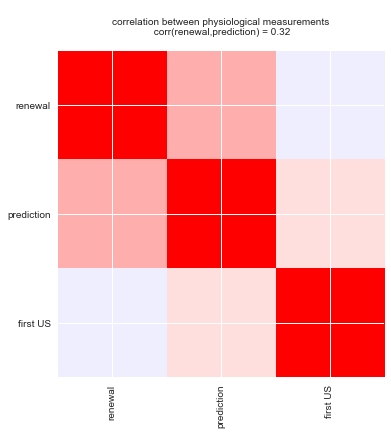

In [423]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([6,6])
ax = imshow(physio.corr())
ax1.set_xticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_xticklabels(physioTitleNames,rotation=90,fontsize=10); 
ax1.set_yticks(np.array(list(range(0,len(physioTitleNames)))))
ax1.set_yticklabels(physioTitleNames,fontsize=10); 
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
title('\ncorrelation between physiological measurements\n corr(renewal,prediction) = %.2f\n'%
      (renewalPredictionCorr),fontsize=10); 

In [64]:
import behavioral_analysis_functions as ba_fun
self_report, subject_names = ba_fun.generate_data_frame()
ba_fun.correlation_matrix(self_report)

ImportError: No module named behavioral_analysis_functions

In [95]:
SCR.index = day2.subjectNames
count = 0
for isubject in range(0, len(SCR)):
    if self_report.index[count] in SCR.index[isubject]: 
        for ikey in self_report.keys():
            SCR.loc[SCR.index[isubject], ikey] =  self_report.loc[self_report.index[count], ikey]
        count = count + 1 
    else: 
        pass

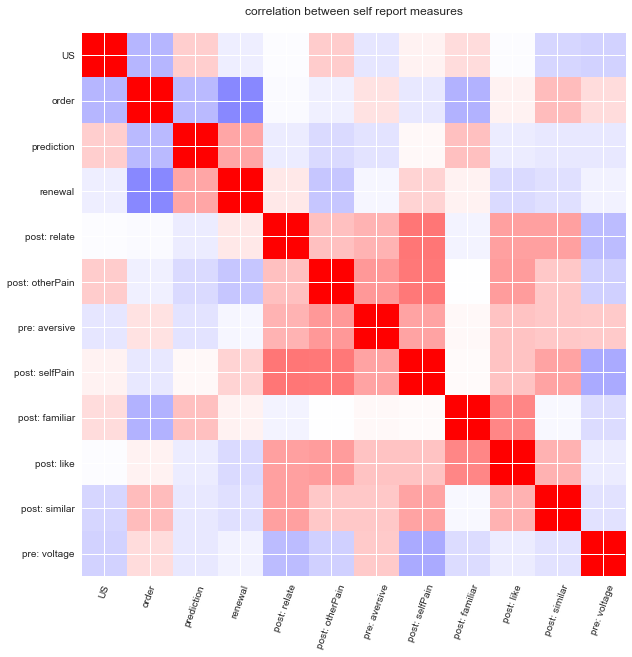

In [96]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches([10,10])
ax = plt.imshow(SCR.corr())
title_names = list(SCR.corr().keys())
ax1.set_xticks(np.array(list(range(0,len(title_names)))))
ax1.set_xticklabels(title_names,rotation=70);
ax1.set_yticks(np.array(list(range(0,len(title_names)))))
ax1.set_yticklabels(title_names);
ax.set_cmap('bwr') # 'coolwarm' # 'seismic'
ax.set_clim([-1,1])
ax.set_alpha(1)
plt.title('correlation between self report measures\n');
#plt.colorbar()
plt.show()

In [97]:
formula = 'renewal ~ prediction + correctColor'
model = ols(formula, SCR).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

AttributeError: 'DataFrame' object has no attribute 'design_info'